# Child Benefit

The Child Benefit is a universal benefit for children administered by HMRC. It is not means-tested, but HMRC does impose a tax charge (the High-Income Tax Charge) on the highest-earning parent if their income is over a threshold to recoup the benefit payment.

Child Benefit parameters can be found in `openfisca_uk/parameters/hmrc/child_benefit` and logic in `openfisca_uk/variables/hmrc/child_benefit.py`.

## Legislation

The Child Benefit is defined primarily in [The Social Security Contributions and Benefits Act 1992, Part IX](https://www.legislation.gov.uk/ukpga/1992/4/part/IX). This defines the core of how the benefit operates, but the rates of payment are prescribed by [The Child Benefit (Rates) Regulations 2006 reg. 2](https://www.legislation.gov.uk/uksi/2006/965/regulation/2), which is amended by up-rating regulations (for example, in 2020, [The Tax Credits, Child Benefit and Guardian’s Allowance Up-rating Regulations 2020](https://www.legislation.gov.uk/uksi/2020/298/regulation/5/made) increased the payment levels).

## Payment levels

Child Benefit defines a (higher) amount for the eldest or only child, and an amount for each additional child. There is no limit on the number of children covered, unlike the Child Tax Credit or the Universal Credit child element. The table below shows the rates covered by OpenFisca-UK.

In [1]:
from openfisca_uk import CountryTaxBenefitSystem
import pandas as pd

parameters = CountryTaxBenefitSystem().parameters
data = {
    "Date": [],
    "Name": [],
    "Value": [],
    "Reference": [],
}

for parameter in parameters.hmrc.child_benefit.amount.eldest.values_list:
    data["Date"] += [parameter.instant_str]
    data["Name"] += ["Eldest"]
    data["Value"] += [f"£{parameter.value:.2f}"]
    data["Reference"] += [
        f"<a href=\"{parameter.metadata['reference'][0]['href']}\">{parameter.metadata['reference'][0]['title']}</a>"
    ]


for parameter in parameters.hmrc.child_benefit.amount.additional.values_list:
    data["Date"] += [parameter.instant_str]
    data["Name"] += ["Additional"]
    data["Value"] += [f"£{parameter.value:.2f}"]
    data["Reference"] += [
        f"<a href=\"{parameter.metadata['reference'][0]['href']}\">{parameter.metadata['reference'][0]['title']}</a>"
    ]


pd.DataFrame(data).sort_values("Date").set_index(
    ["Date", "Name"]
).style.format(lambda x: x)

## Examples

The below table shows the entitlement calculations for a family of increasing size.

In [2]:
from openfisca_uk import IndividualSim


def get_cb_for_n_children(n):
    sim = IndividualSim(year=2022)
    for i in range(n):
        sim.add_person(age=10, name=str(i))
    sim.add_benunit(children=[str(i) for i in range(n)])
    return f'£{sim.calc("child_benefit").sum():.2f}'


pd.DataFrame(
    {
        "Number of children": list(range(1, 7)),
        "Child Benefit (Annual)": list(
            map(get_cb_for_n_children, range(1, 7))
        ),
    }
).set_index("Number of children")

,Child Benefit (Annual)
Number of children,
1,£1099.80
2,£1827.80
3,£2555.80
4,£3283.80
5,£4011.80
6,£4739.80


## Microsimulation

OpenFisca-UK simulates Child Benefit as described for each family in the survey microdata, and subsequently applies a take-up correction, as not all families who are eligible in reality will claim the benefit. Child Benefit has a relatively high take-up rate compared to other benefits, most recently estimated at 92%. We use the central estimates from 2006 through 2018, provided by HMRC [Child Benefit Statistics: Annual Release, August 2020 Main Commentary | Table 3.1](https://www.gov.uk/government/statistics/child-benefit-statistics-annual-release-august-2020/child-benefit-statistics-annual-release-august-2020-main-commentary), which are calculated from microsimulation and administrative data held by HMRC.

## Validation

OpenFisca-UK matches administrative statistics closely, due to the simplicity of the calculations. The Department for Work and Pensions publishes benefit expenditure and caseload tables every year: below, we use the [2021 release](https://www.gov.uk/government/publications/benefit-expenditure-and-caseload-tables-2021) (the latest at the time of writing) release to compare against OpenFisca-UK. The table and graph below also show the aggregate spending estimated by UKMOD, as per the latest [country report](https://www.iser.essex.ac.uk/research/publications/working-papers/cempa/cempa7-20.pdf#page=129).

The administrative spending figures include Guardian's Allowance, whereas OpenFisca-UK and UKMOD do not. Between 2018 and 2021, the DWP replaced previous forecasts with outturn data, revising the forecast aggregate spending for 2018, 2019 and 2020 down by £119m, £250m and £455m, respectively.

In [3]:
from openfisca_uk import Microsimulation
from openfisca_uk_data import FRSEnhanced

sim_2018 = Microsimulation(year=2018)
sim_2019 = Microsimulation(year=2019)

cb_2018 = int(sim_2018.calc("child_benefit").sum() / 1e6)
cb_2019_onwards = [
    int(sim_2019.calc("child_benefit", year).sum() / 1e6)
    for year in range(2019, 2023)
]

aggregates = pd.DataFrame(
    {
        "OpenFisca-UK Aggregate (£m)": [cb_2018, *cb_2019_onwards],
        "Year": list(range(2018, 2023)),
        "Official Estimate (£m)": [11_170, 11_081, 11_116, 10_981, 11_213],
        "Official Estimate Type": ["Outturn"] * 3 + ["Forecast"] * 2,
        "UKMOD Aggregate (£m)": [11_480, 11_432, 11_621, 11_573, 11_668],
    }
)
aggregates["Absolute Error (£m)"] = (
    aggregates["Official Estimate (£m)"]
    - aggregates["OpenFisca-UK Aggregate (£m)"]
)
aggregates["Relative Error (%)"] = 100 * (
    aggregates["OpenFisca-UK Aggregate (£m)"]
    / aggregates["Official Estimate (£m)"]
    - 1
).round(3)

aggregates.set_index("Year")

,OpenFisca-UK Aggregate (£m),Official Estimate (£m),Official Estimate Type,UKMOD Aggregate (£m),Absolute Error (£m),Relative Error (%)
Year,,,,,,
2018,11090,11170,Outturn,11480,80,-0.7
2019,11096,11081,Outturn,11432,-15,0.1
2020,11096,11116,Outturn,11621,20,-0.2
2021,11289,10981,Forecast,11573,-308,2.8
2022,11338,11213,Forecast,11668,-125,1.1


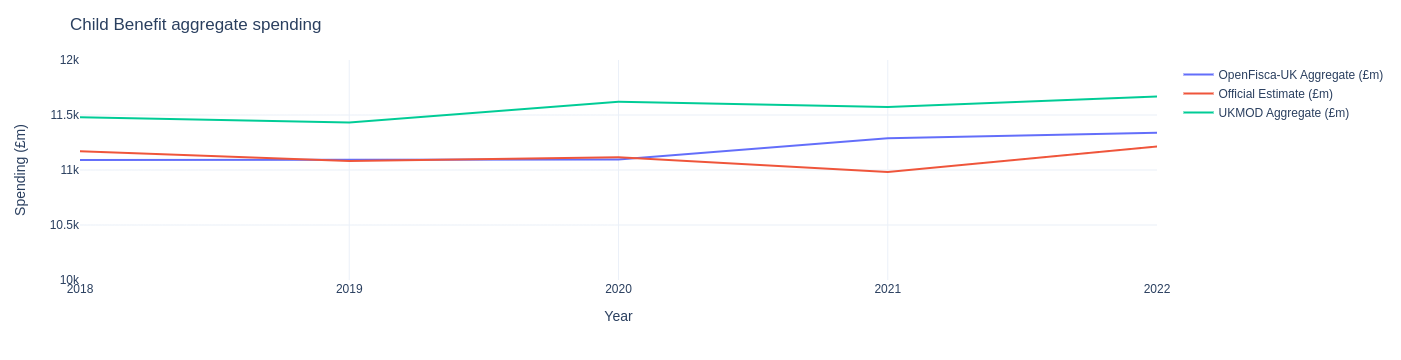

In [7]:
import plotly.express as px

px.line(
    aggregates,
    x="Year",
    y=[
        "OpenFisca-UK Aggregate (£m)",
        "Official Estimate (£m)",
        "UKMOD Aggregate (£m)",
    ],
).update_layout(
    template="plotly_white",
    title="Child Benefit aggregate spending",
    xaxis_tickvals=list(range(2018, 2023)),
    yaxis_title="Spending (£m)",
    legend_title="",
    yaxis_range=(10_000, 12_000),
)